# 🔬 Beijing Air Quality
## 📘 Notebook 07 – Hypothesis 4: Temporal Structure in PM2.5

| Field         | Description                                        |
|:--------------|:---------------------------------------------------|
| Author:       |	Robert Steven Elliott                            |
| Course:       |	Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Capstone                                         |
| Date:         |	December 2025                                    |

This project complies with the CC BY 4.0 licence by including proper attribution.


## Objectives

- Evaluate Hypothesis 4: Temporal structure explains PM2.5 variation.
- Investigate temporal patterns using:
    - `hour`
    - `month`
    - `year`
    - `season`
    - `day_of_week` 
    - Autocorrelation (lag dependence)
- Determine whether PM2.5 follows:
    - Daily cycles
    - Monthly/seasonal cycles
    - Long-term temporal trends
    - Autocorrelation patterns relevant for modelling
- Provide evidence for accepting or rejecting H4.


## Inputs

- Dataset: `data/cleaned/beijing_cleaned.parquet`
- Required columns:
    - `pm25`
    - `year`
    - `month`
    - `day`
    - `hour`
    - `day_of_week`
    - `season`
    - `datetime`


## Outputs

- Temporal distribution plots
- Spearman correlations with time variables
- Autocorrelation plots (ACF/PACF)
- Observations + justification
- Final decision on Hypothesis 4


## Citation  
This project uses data from:

Chen, Song (2017). *Beijing Multi-Site Air Quality.*  
UCI Machine Learning Repository — Licensed under **CC BY 4.0**.  
DOI: https://doi.org/10.24432/C5RK5G  
Kaggle mirror by Manu Siddhartha.

---

## Hypothesis Introduction

PM2.5 concentrations often follow recurring temporal cycles driven by human behaviour (traffic patterns), meteorological conditions, and seasonal factors. Understanding these patterns helps determine whether time itself is a meaningful predictor of PM2.5.

$$
\begin{aligned}
H_0 &: \text{PM2.5 levels do not exhibit temporal structure.} \\
H_1 &: \text{PM2.5 levels show significant temporal patterns such as daily, monthly, or seasonal cycles.}
\end{aligned}
$$

### Purpose of This Notebook

This notebook evaluates the degree to which PM2.5 levels vary according to time-based patterns, including:

- Daily cycles (hour-of-day variation)
- Monthly/seasonal cycles
- Long-term yearly trends
- Autocorrelation (dependence on previous hours)

By analysing these structures, we can:
- Assess the validity of Hypothesis 4
- Identify temporal features useful for forecasting (H5)
- Understand human and environmental drivers of PM2.5 variability

This builds directly on insights from earlier notebooks.

## Notebook Setup

### Import Required Libraries

(The following libraries support analysis, plotting, and data manipulation.)

In [1]:
import sys # system-level operations
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # statistical data visualization
import plotly.express as px # interactive plotting
from scipy.stats import spearmanr# statistical tests
from pathlib import Path # filesystem paths
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation plots

### Configure Visual Settings

In [2]:

plt.style.use("seaborn-v0_8") # set matplotlib style
sns.set_theme() # set seaborn theme

### Set Up Project Paths

In [3]:
PROJECT_ROOT = Path.cwd().parent # Assuming this script is in a subdirectory of the project root
DATA_PATH = PROJECT_ROOT / "data" # Path to the data directory

sys.path.append(str(PROJECT_ROOT)) # Add project root to sys.path

FIGURES_PATH = PROJECT_ROOT / "figures" / "h4" # Path to save figures
FIGURES_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist
INPUT_PATH = DATA_PATH / "cleaned" / "beijing_cleaned.csv" # input file path
print("Input path :", INPUT_PATH) # Print input path

Input path : /home/robert/Projects/beijing-air-quality/data/cleaned/beijing_cleaned.csv


### Load Dataset

In [4]:
df = pd.read_csv(INPUT_PATH) # Load cleaned data
df.head() # Display first few rows of the dataframe

,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,wind_direction,wind_speed,station,latitude,longitude,area_type,season,day_of_week
0,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,guanyuan,39.941746,116.361478,urban,spring,4
1,2013-03-01 00:00:00,2013,3,1,0,3.0,-2.3,1020.8,-19.7,0.0,E,0.5,changping,40.220772,116.231204,suburban,spring,4
2,2013-03-01 00:00:00,2013,3,1,0,6.0,0.1,1021.1,-18.6,0.0,NW,4.4,gucheng,39.908156,116.239596,residential,spring,4
3,2013-03-01 00:00:00,2013,3,1,0,8.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,wanliu,39.990376,116.287252,residential,spring,4
4,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,aotizhongxin,40.003388,116.407613,urban,spring,4


## Data Overview Analysis

(Understanding structure, completeness, and variable types.)

### Structure + Missing Values

In [5]:
df["datetime"] = pd.to_datetime(df["datetime"]) # Convert 'datetime' column to datetime
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype("category") # Convert 'object' column to category dtype

In [6]:
print("Dataframe Info:") # Display dataframe info
display(df.info()) # Display dataframe info
print("\nDataframe Shape:") # Display dataframe shape
display(df.shape) # Display dataframe shape
print("\nMissing Values:") # Check for missing values
display(df.isna().sum()) # Check for missing values

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403776 entries, 0 to 403775
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        403776 non-null  datetime64[ns]
 1   year            403776 non-null  int64         
 2   month           403776 non-null  int64         
 3   day             403776 non-null  int64         
 4   hour            403776 non-null  int64         
 5   pm25            403776 non-null  float64       
 6   temperature     403776 non-null  float64       
 7   pressure        403776 non-null  float64       
 8   dew_point       403776 non-null  float64       
 9   rain            403776 non-null  float64       
 10  wind_direction  403776 non-null  category      
 11  wind_speed      403776 non-null  float64       
 12  station         403776 non-null  category      
 13  latitude        403776 non-null  float64       
 14  longitude       4037

None


Dataframe Shape:


(403776, 18)


Missing Values:


datetime          0
year              0
month             0
day               0
hour              0
pm25              0
temperature       0
pressure          0
dew_point         0
rain              0
wind_direction    0
wind_speed        0
station           0
latitude          0
longitude         0
area_type         0
season            0
day_of_week       0
dtype: int64

## Temporal Distributions

### Hourly Variation

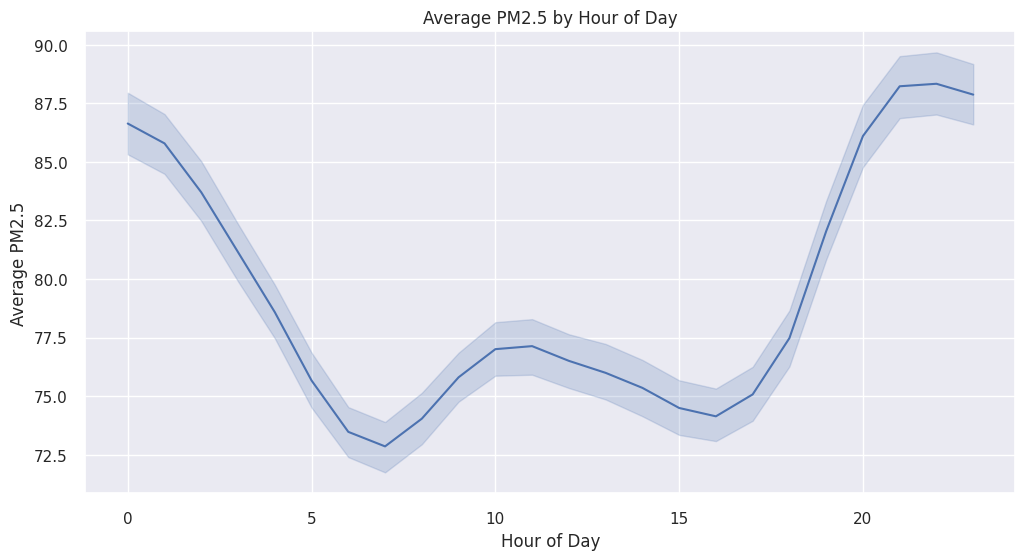

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="hour", y="pm25", estimator="mean")
plt.title("Average PM2.5 by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_hour.png")
plt.show()

### Daily Variation

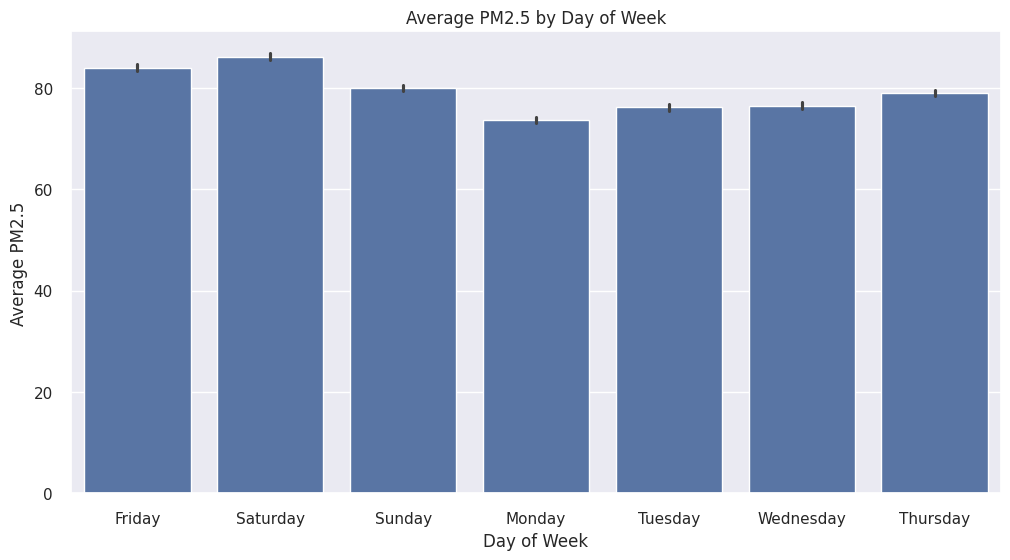

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x=df['datetime'].dt.day_name(), y="pm25", estimator="mean")
plt.title("Average PM2.5 by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_day_of_week.png")
plt.show()

### Monthly Variation

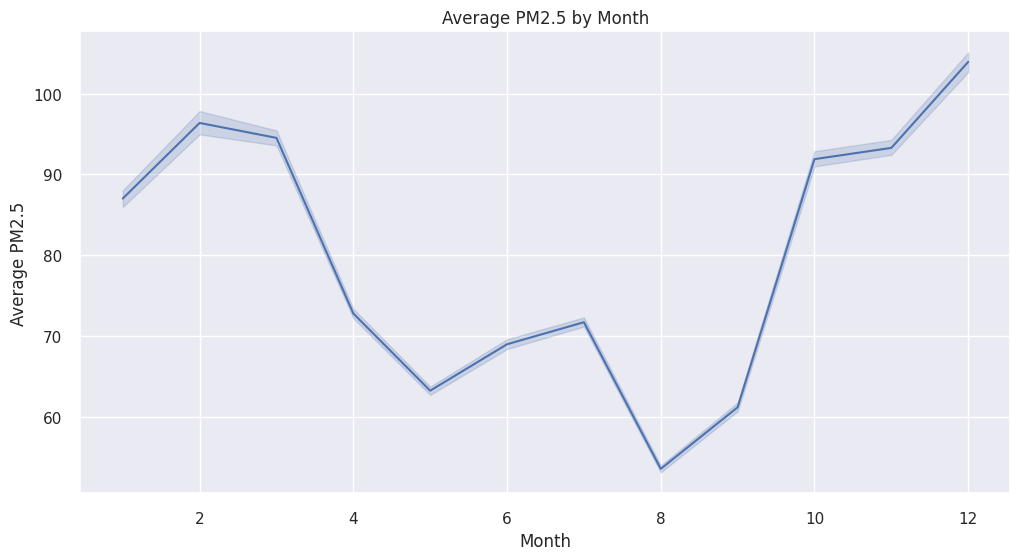

In [9]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="month", y="pm25", estimator="mean")
plt.title("Average PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_month.png")
plt.show()

### Seasonal Variation

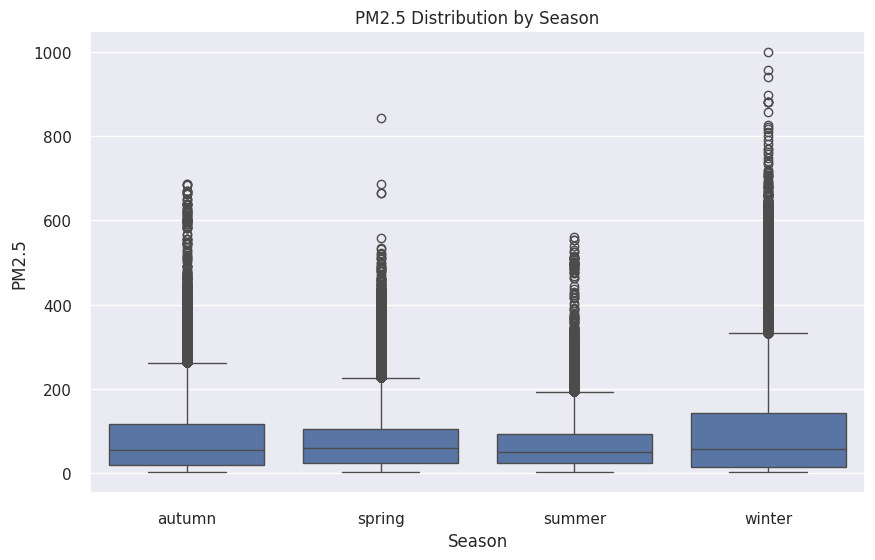

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="season", y="pm25")
plt.title("PM2.5 Distribution by Season")
plt.xlabel("Season")
plt.ylabel("PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_season.png")
plt.show()

### Yearly Variation

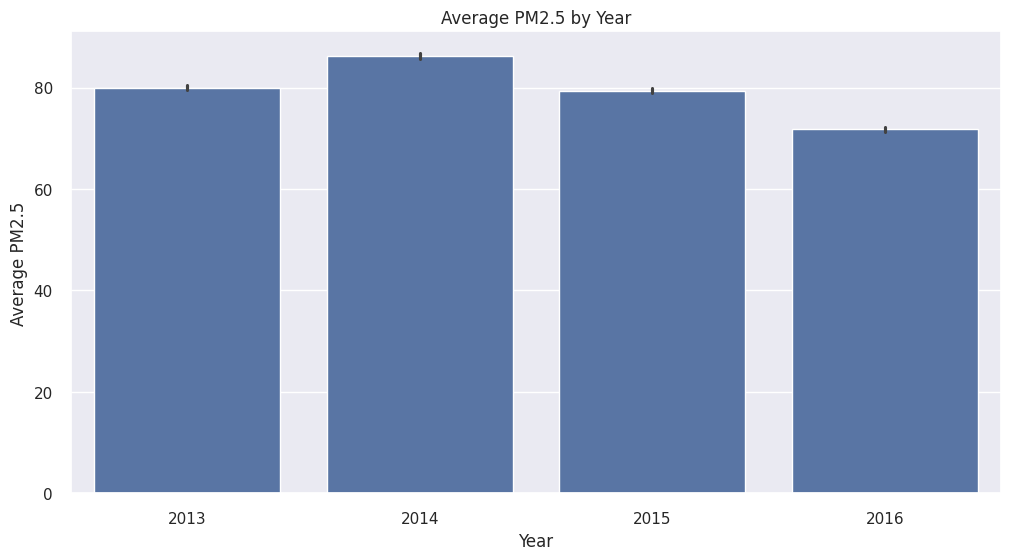

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="year", y="pm25", estimator="mean")
plt.title("Average PM2.5 by Year")
plt.xlabel("Year")
plt.ylabel("Average PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_year.png")
plt.show()

## Autocorrelation (ACF & PACF)

These plots help assess whether PM2.5 values depend on previous hours — important for forecasting models.

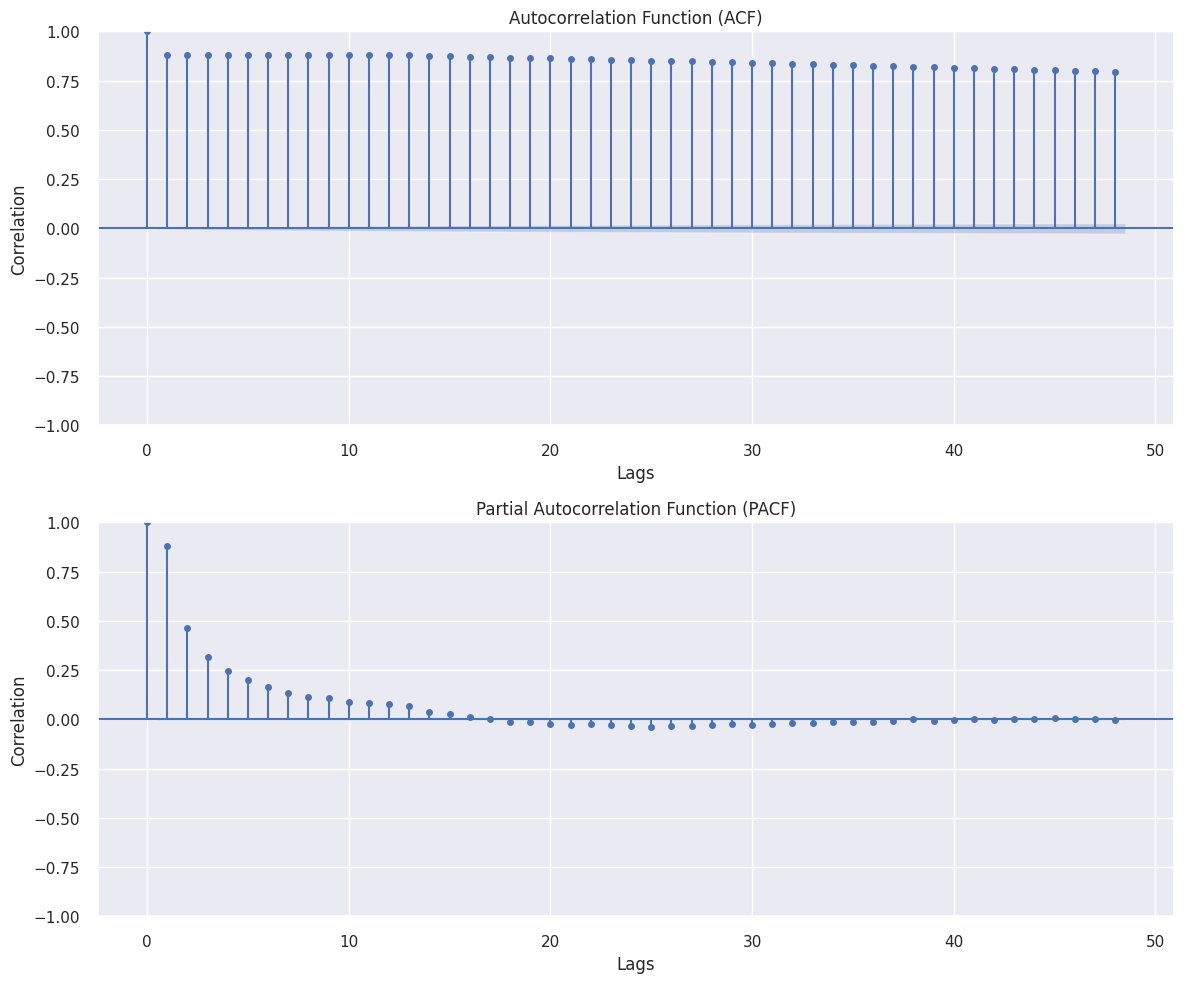

In [12]:
pm = df["pm25"].dropna()

fig, axes = plt.subplots(2, 1, figsize=(12,10))
plot_acf(pm, ax=axes[0], lags=48)
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Correlation")

plot_pacf(pm, ax=axes[1], lags=48, method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Correlation")

plt.tight_layout()
plt.savefig(FIGURES_PATH / "pm25_acf_pacf.png")
plt.show()

## Spearman Correlation with Temporal Variables

#Spearman is appropriate because temporal variables are ordinal or cyclical, though results should be interpreted cautiously due to cyclic behaviour.

In [13]:
time_vars = ["hour", "month", "day_of_week", "season", "year"]

results = []

for var in time_vars:
    coef, p = spearmanr(df["pm25"], df[var])
    results.append({"Variable": var, "Spearman ρ": coef, "p-value": p})

spearman_time_df = pd.DataFrame(results)
spearman_time_df

,Variable,Spearman ρ,p-value
0,hour,0.010145,1.142957e-10
1,month,-0.006582,2.882713e-05
2,day_of_week,0.041107,1.601956e-150
3,season,-0.007750,8.456744e-07
4,year,-0.067635,0.000000e+00


## Observations

- Spearman correlations for the temporal variables show statistically significant but numerically small values.
- This is expected because temporal effects in air pollution are cyclical rather than monotonic, meaning Spearman underestimates their strength.
- Despite small ρ values, p-values are extremely low, reflecting consistent temporal structure across hundreds of thousands of observations.
- Visual analysis (hourly, monthly, seasonal plots) clearly shows strong temporal patterns that correlation coefficients alone cannot capture.
- `year` shows a small but statistically significant negative monotonic relationship with PM2.5, consistent with the known year-on-year improvement in Beijing air quality due to policy interventions. Although numerically small, the extremely low p-value indicates a real long-term downward trend.
- The `day-of-week` effect is the strongest of the short-term temporal variables, confirming subtle weekday–weekend differences in pollution behaviour.



## Justification

Spearman correlation is used to evaluate monotonic relationships with temporal variables; however, variables such as `hour`, `month`, and `season` exhibit cyclical rather than monotonic behaviour. Because Spearman is not designed for cyclic data, it produces small coefficients even when clear temporal structure exists. The extremely low p-values confirm that these patterns are statistically meaningful despite their low ρ values.

Together with the strong visual evidence from hourly, monthly, and seasonal analyses, and the clear autocorrelation structure, these results support the conclusion that temporal patterns significantly influence PM2.5 levels.

Including `year` captures long-term regulatory and environmental changes not represented in hourly or seasonal cycles. The small Spearman coefficient is expected due to the short four-year span, but the statistically significant p-value confirms a meaningful downward temporal trend.


## Conclusion – Hypothesis 4: Temporal Structure in PM2.5

The analysis provides strong evidence that PM2.5 levels exhibit clear and meaningful temporal structure across hourly, monthly, and seasonal timescales. The presence of autocorrelation further demonstrates that recent PM2.5 values influence future concentrations.

### Hypothesis 4 is accepted:

Temporal structure provides significant explanatory value for PM2.5 variation.

## Transition to Feature Engineering

With the temporal, spatial, meteorological, and seasonal patterns fully validated across Hypotheses 1–4, the analytical phase of the project is complete. The next step is to prepare the dataset for predictive modelling by engineering features that can capture the time-dependent structure identified in Hypothesis 4.

In the following notebook, Feature Engineering will be performed to create lag variables, rolling averages, interaction terms, and cyclical encodings. These engineered features will form the basis of Hypothesis 5, which evaluates whether lagged PM2.5 values improve forecasting performance.

---

### AI Assistance Note

Some narrative text and minor formatting or wording improvements in this notebook were supported by AI-assisted tools (ChatGPT for documentation clarity, Copilot for small routine code suggestions, and Grammarly for proofreading). All analysis, code logic, feature engineering, modelling, and interpretations were independently created by the author.